## Characters influencing pollinator shift in the genus Fritillaria

![Fritillaria](Fritillaria_Flowers.jpg)

In [1]:
#import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import plot_importance, plot_tree
import graphviz
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools
from functools import reduce

In [2]:
#nectar, morphology and flower structure data
data = pd.read_csv("PELNE DANE.csv", delimiter=";", decimal=",")
#aminoacids, nectar proprerties
amino = pd.read_csv("aminokwasy.csv")
nectar = data.copy()
#reflectancy
xls = pd.ExcelFile('Fritillaria Warsaw.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 26 columns):
Gatunek    3029 non-null object
KOL        3029 non-null object
APZ        152 non-null float64
APW        147 non-null float64
D1         451 non-null float64
D2         452 non-null float64
PS         439 non-null float64
R          2519 non-null float64
SC         424 non-null float64
PL         2570 non-null float64
PYL        2564 non-null float64
K-J        2725 non-null float64
PYLZN      2212 non-null float64
PYLPL      2528 non-null float64
ZN         453 non-null float64
SZY        339 non-null float64
NB         249 non-null float64
KAT        278 non-null float64
V          505 non-null float64
KON        572 non-null float64
MASA       477 non-null float64
POW        948 non-null float64
NAS        793 non-null float64
WYS        793 non-null float64
SZER       793 non-null float64
SZEW       606 non-null float64
dtypes: float64(24), object(2)
memory usage: 615.3+ KB


* Gatunek - species
* KOL - colour of the flower (1 - greenish, 2 - white, 3 - claret, 4 - yellow, 5 - orange, 6 -pink, 7 - red, 1/3 -greenish and claret )
* APZ - stomata of the outer tepal
* APW - stomata of the inner tepal
* D1 - horizontal diagonal of flower
* D2 - vertical diagonal of flower
* PS - diagonal of the entrance
* R - PS / PL
* SC - scape length
* PL - petalas diagonal
* PYL - anthers length
* K-J - PL - PYL
* PYLZN - distance between stigma and anther
* PYLPL - distance between tepals and anther
* ZN - style length
* SZY - stigma length
* NB - number of flowers
* KAT -angle between flower's diagonal and scape
* V - nectar volume
* KON - nectar concentration
* MASA - nectar mass
* POW - area of nectaries
* NAS - distiance between the petal and the nectary
* WYS - nectary hight
* SZER - nectary width
* SZEW - diagonal of the scape

In [4]:
amino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 38 columns):
Gatunek              53 non-null object
SEZON                53 non-null object
ORIGIN               53 non-null object
dominujący cukier    48 non-null object
ASP                  53 non-null float64
GLU                  53 non-null float64
ASN                  53 non-null float64
SER                  53 non-null float64
GLN                  53 non-null float64
GLY                  53 non-null float64
THR                  53 non-null float64
VAL                  53 non-null float64
MET                  53 non-null float64
LEU                  53 non-null float64
LYS                  53 non-null float64
ARG                  53 non-null float64
BALA                 53 non-null float64
ALA                  53 non-null float64
TYR                  53 non-null float64
PRO                  53 non-null float64
TRP                  53 non-null float64
PHE                  53 non-null float64

* Gatunek - species of the flower, 
* SEZON - year of study, 
* ORIGIN - origin of the flower, 
* dominujący cukier - sugar,
* ASP', 'GLU', 'ASN', 'SER', 'GLN', 'GLY', 'THR', 'VAL', 'MET', 'LEU', 'LYS', 'ARG', 'BALA', 'ALA','TYR', 'PRO', 'TRP', 'PHE', 'ILE', 'AABA', 'CY2', 'OSER+HIS', 'CIT','NVA', 'ORN', 'TAU', 'GABA', 'HYP', 'SAR', 'BABA' - aminoacids in nectar, 
* v - nectar volume, 
* % - nectar concentration, 
* pollinator - main pollinator

In [5]:
amino.columns

Index(['Gatunek', 'SEZON', 'ORIGIN', 'dominujący cukier', 'ASP', 'GLU', 'ASN',
       'SER', 'GLN', 'GLY', 'THR', 'VAL', 'MET', 'LEU', 'LYS', 'ARG', 'BALA',
       'ALA', 'TYR', 'PRO', 'TRP', 'PHE', 'ILE', 'AABA', 'CY2', 'OSER+HIS',
       'CIT', 'NVA', 'ORN', 'TAU', 'GABA', 'HYP', 'SAR', 'BABA', 'suma', 'v',
       '%', 'pollinator'],
      dtype='object')

In [6]:
#removing unecessary colums
data.drop(["R", "K-J", "APZ", "APW"], axis=1, inplace=True)
amino.drop(["suma", 'SEZON'], axis=1, inplace=True)

In [7]:
#returns subspecies
def subgenus(name):
    if ((name == 'F. amabilis') | (name == 'F. ayakoana')):
        return "Japonica"
    elif ((name == 'F. affinis') | (name == 'F. gentneri') | (name == 'F. camtschatcensis') | 
          (name == 'F. eastwoodiae') | (name == 'F. liliacea') | (name == 'F. recurva')): 
        return "Liliorhiza"
    elif (name == 'F. sewerzowii'):
        return "Korolkowia"
    elif ((name == 'F. eduardii') | (name == 'F. imperialis') | (name == 'F. raddeana')):
        return "Petilium"
    elif ((name == 'F. bucharica') | (name == 'F. sthenanthera')):
        return "Rhinopetalum"
    elif (name == 'F. persica'):
        return "Theresia"
    elif ((name == 'F. grandiflora') | (name == 'F. olgae')):
        return "Other"
    else:
        return "Fritillaria"

In [8]:
#returns main pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == 'F. camtchatcensis') | (name == 'F. drenovskii') | (name == 'F. graeca') | 
          (name == 'F. pyrenaica') | (name == 'F. thessala') | (name == 'F. ussuriensis')):
        return "FLY"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "BEE"

In [9]:
#adding columns with subspecies and main pollinator name 
data['Subspecies'] = data['Gatunek'].apply(subgenus)
data['Pollinator'] = data['Gatunek'].apply(pollinator)

In [10]:
#mean for nectar features group by species
df = data.groupby(['Gatunek']).agg({'V': 'mean', 'KON': 'mean', 
                                    'MASA':'mean'}).reset_index()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
Gatunek    73 non-null object
V          44 non-null float64
KON        49 non-null float64
MASA       38 non-null float64
dtypes: float64(3), object(1)
memory usage: 2.4+ KB


In [12]:
df.dropna(inplace=True)

In [13]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)
df['Subspecies'] = df["Gatunek"].apply(subgenus)

## Flower characters

In [14]:
# mean of angle and diagonal of flower
flow_prop = data.groupby(['Gatunek']).agg({'V': 'mean','KAT': 'mean',
                                   'PS': 'mean'}).reset_index()

In [15]:
flow_prop['Pollinator'] = flow_prop["Gatunek"].apply(pollinator)

In [16]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
flow_prop["colors"] = flow_prop.Pollinator.apply(lambda x: col[x])

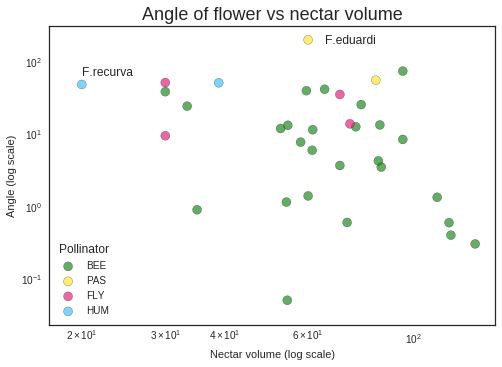

In [17]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = flow_prop.KAT[flow_prop.Pollinator == key], 
                y = flow_prop.V[flow_prop.Pollinator == key],
                s = 80,
                c = flow_prop.colors[flow_prop.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Angle (log scale)')
plt.title('Angle of flower vs nectar volume', fontsize=18)

plt.text(20, 64, 'F.recurva')
plt.text(65, 180, 'F.eduardi')
plt.legend(labels, title = "Pollinator", loc = 'lower left')

plt.show()

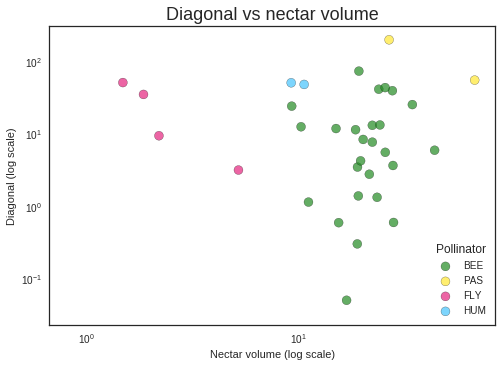

In [18]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = flow_prop.PS[flow_prop.Pollinator == key], 
                y = flow_prop.V[flow_prop.Pollinator == key],
                s = 80,
                c = flow_prop.colors[flow_prop.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Diagonal (log scale)')
plt.title('Diagonal vs nectar volume', fontsize=18)

#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
#plt.text(120, 24, 'F.imperialis')
#plt.text(70, 4, 'F.eduardi')

plt.legend(labels, title = "Pollinator", loc = 'lower right')
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 24 columns):
Gatunek       3029 non-null object
KOL           3029 non-null object
D1            451 non-null float64
D2            452 non-null float64
PS            439 non-null float64
SC            424 non-null float64
PL            2570 non-null float64
PYL           2564 non-null float64
PYLZN         2212 non-null float64
PYLPL         2528 non-null float64
ZN            453 non-null float64
SZY           339 non-null float64
NB            249 non-null float64
KAT           278 non-null float64
V             505 non-null float64
KON           572 non-null float64
MASA          477 non-null float64
POW           948 non-null float64
NAS           793 non-null float64
WYS           793 non-null float64
SZER          793 non-null float64
SZEW          606 non-null float64
Subspecies    3029 non-null object
Pollinator    3029 non-null object
dtypes: float64(20), object(4)
memory usage: 568.

In [20]:
#removing cols with to many missing values - (NB, SZEW, SZY) and with nectar prop.
data.drop(["V", "MASA", "KON","Subspecies", "D1", "D2", "NB", "KAT", "SZY", "SZEW","PS", "SC","ZN", "NAS", "WYS", "SZER"], axis=1, inplace=True)

In [21]:
columns = data.columns
columns[2:12]

Index(['PL', 'PYL', 'PYLZN', 'PYLPL', 'POW', 'Pollinator'], dtype='object')

In [22]:
#filling na's with mean value for each species
for i in range(2,7):
    data.loc[data[columns[i]].isnull(), columns[i]] = data.groupby('Gatunek')[columns[i]].transform('mean')

In [23]:
data = data.dropna()

In [24]:
data.drop("Gatunek", axis=1, inplace=True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2821 entries, 0 to 3015
Data columns (total 7 columns):
KOL           2821 non-null object
PL            2821 non-null float64
PYL           2821 non-null float64
PYLZN         2821 non-null float64
PYLPL         2821 non-null float64
POW           2821 non-null float64
Pollinator    2821 non-null object
dtypes: float64(5), object(2)
memory usage: 176.3+ KB


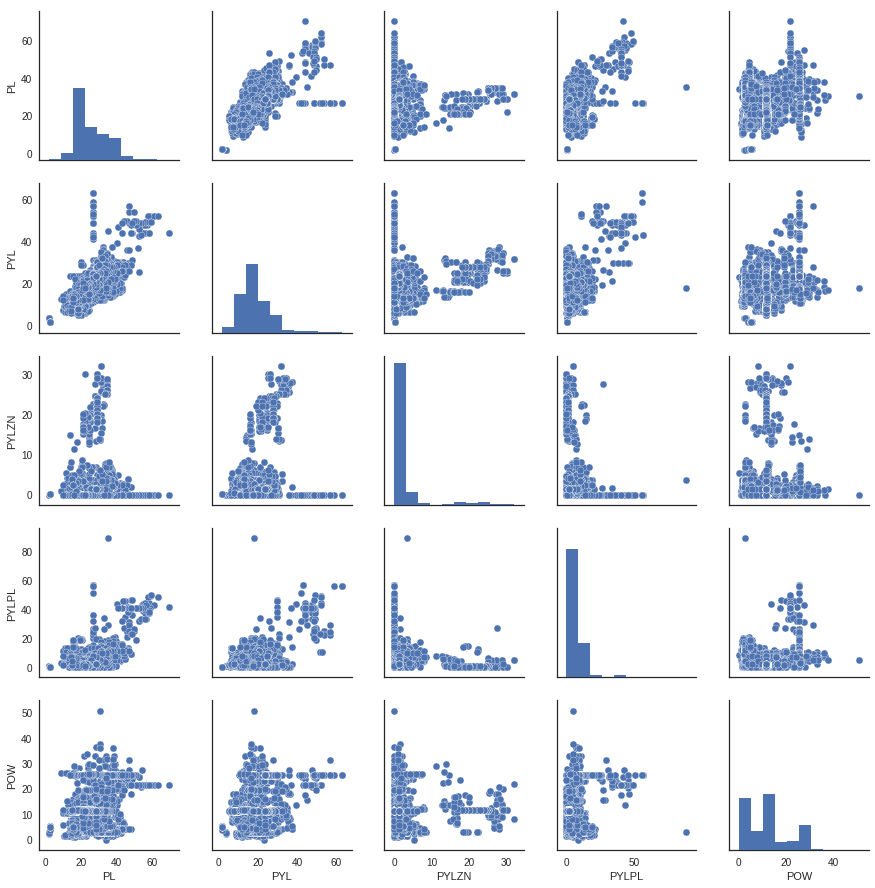

In [26]:
sns.pairplot(data)
plt.show()

In [27]:
data['PYL'].corr(data['PL'])

0.7328691450186815

In [28]:
data.drop("PL", axis=1, inplace=True)

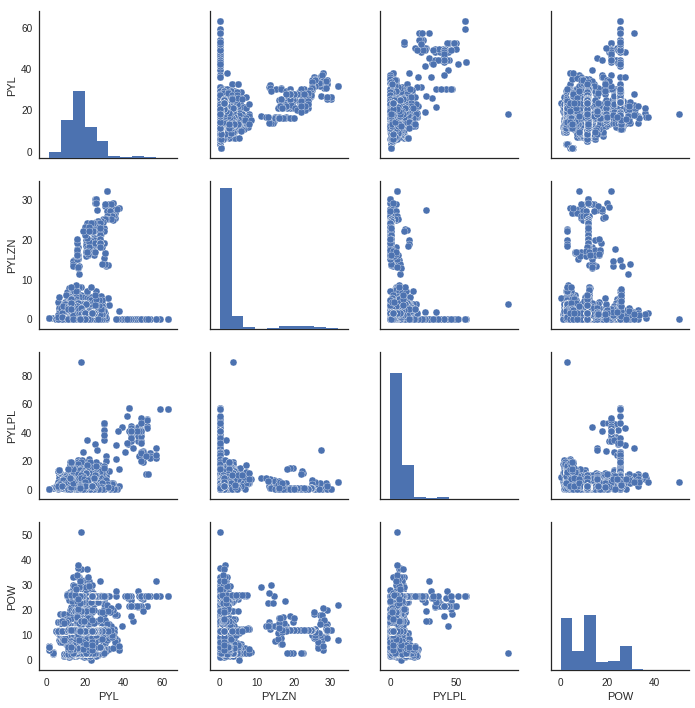

In [29]:
sns.pairplot(data.iloc[:,1:10])
plt.show()

In [30]:
X = data.drop("Pollinator", axis=1)
y = data.Pollinator

In [31]:
y.value_counts()

BEE    2235
PAS     399
HUM     140
FLY      47
Name: Pollinator, dtype: int64

In [32]:
X = pd.get_dummies(X,drop_first=True)
columnX = X.columns

In [33]:
le = LabelEncoder()
le.fit(y)
y_e = le.transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_e, test_size=0.25, random_state=42)

In [35]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(probability=True),  
          RandomForestClassifier(), 
          AdaBoostClassifier(),
         xgb.XGBClassifier()]

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = np.round(y_pred)

    accuracy = accuracy_score(y_test, predictions)
    print("%s accuracy: %.2f%%" % (model.__class__.__name__,accuracy * 100.0))

LogisticRegression accuracy: 98.44%
DecisionTreeClassifier accuracy: 99.29%
SVC accuracy: 98.02%
RandomForestClassifier accuracy: 99.58%
AdaBoostClassifier accuracy: 98.44%
XGBClassifier accuracy: 99.58%


In [36]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [37]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [38]:
labels = ["BEE","HUM","FLY", "PAS"]

Confusion matrix, without normalization
[[563   0   0   0]
 [  3   8   0   0]
 [  0   0  36   0]
 [  0   0   0  96]]


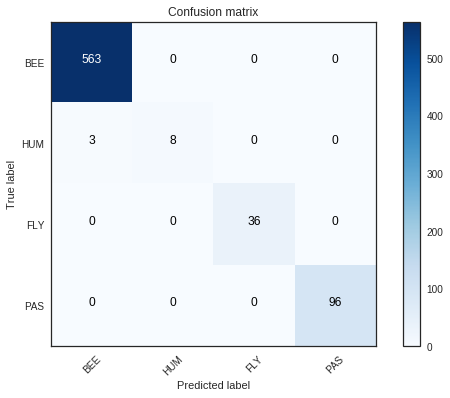

In [39]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=labels,
                      title='Confusion matrix')
plt.show()

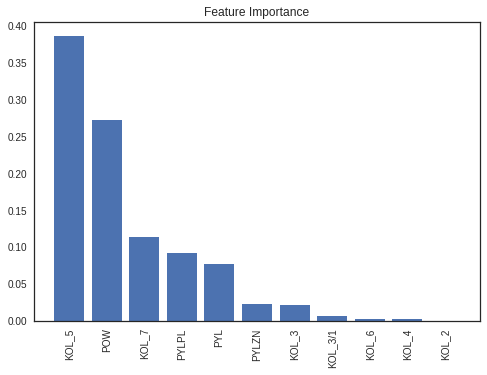

In [40]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [columnX[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       563
          1       1.00      0.73      0.84        11
          2       1.00      1.00      1.00        36
          3       1.00      1.00      1.00        96

avg / total       1.00      1.00      1.00       706



Flower features can determine which pollinators or group of pollinators will be attracted. Moreover, the character and the location of the reward influence the species which are attracted. Our Fritillaria study indicates that foundation for the pollinators switch might be the quality and the quantity of the reward offered in the flower. However, such shift seems unlikely to generate reproductive isolation. Our analysis indicated flower color (orange), the area of the nectary (POW) and anthers length (PYL) as a key features cosing pollinator shift.

## Reflectance

Flowers serve as filters signalling attractants for pollinators as well as deterrents for flower antagonists. Due to differences in the number of photoreceptors types, the spectral range of sensitivity of the colour photoreceptors, and differences in the colour preference of various flower visitors, flowers can be attractive to pollinators and unattractive to illegitimate visitors, i.e. pollen thieves and nectar robbers, at the same time. Since many flower visitors, such as hummingbirds, bees, hoverflies, beetles, butterflies and moths are sensitive to ultraviolet light, these flower visitors necessarily view different aspects of the spectral reflectance of flowers as compared to UV-blind humans.(Verhoeven et al. 2018)

![Spectral sensitivity](spectral_sensitivity.jpg)

In [42]:
names = xls.sheet_names

### Nectaries

In [43]:
#searching for "nectaries" in sheets name
nectaries = []
pattern = ".+nectari"
nectaries = [x for x in names if re.match(pattern,x)]

In [44]:
#getting indexes of "nectaries" sheets
index_nec = []
for i in range(len(nectaries)):
    index_nec.append(names.index(nectaries[i]))   

In [45]:
#nectaries sheets
sheets_nect = []
for i in range(len(nectaries)):
    sheet = xls.parse(index_nec[i])
    sheets_nect.append(sheet)

In [46]:
#columns wiht reflectance value
columns_ref = sheets_nect[0].columns[1::2]

In [47]:
#selcecting UV & visible spectrum
for i in range(len(sheets_nect)):
    sheets_nect[i] = sheets_nect[i][(sheets_nect[i].nm > 300) & (sheets_nect[i].nm < 700)]

In [48]:
#mean of reflectance value
for i in range(len(sheets_nect)):
    sheets_nect[i] = sheets_nect[i].assign(mean=sheets_nect[i][columns_ref].mean(axis=1)/1000)

In [49]:
#list of analysed species
species = ["F. imperialis","F. michailovskyi",'F. whittallii','F. tubiformis','F. gracilis',
           'F. eduardii','F. minima','F. thunbergii','F. eastwoodiae', "F. liliaceae", 
           "F. liliaceae", "F. kurdica",'F. pyrenaica', 'F. pontica', 'F. thunbergii',
           'F. uva vulpis', 'F. affinis','F. montana',  'F. aryiana', 'F. dasyphylla', 
           'F. verticillata','F. serpenticola', 'F. mutabilis', 'F. raddeana', 'F. graeca', 
           'F. caucasica', 'F. gibbosa', 'F. armena','F. stenanthera','F. ussuriensis',
           'F. kotschyana','F. meleagris', "F. michailovskyi", 'F. latakesis', 'F. gentneri',
          'F. recurva', 'F. sewerzowii', 'F. messanensis']

In [50]:
#changing labels for species name
nect_sp=[]
for i in range(len(nectaries)):
    nect_sp.append(nectaries[i].replace('Sp'+str(i+1), species[i]))

In [51]:
nect_species = []
for i in range(len(nect_sp)):
    nect_species.append(nect_sp[i].replace(" nectaries", ""))

In [52]:
col_nect = ("#000000", "#ff1493", "#187e03", "#a8224a", "#58559c", "#ffb653", "#0d8dd7", 
            "#eaec32", "#ff0000", "#3701fe", "#fff138", "#767676")

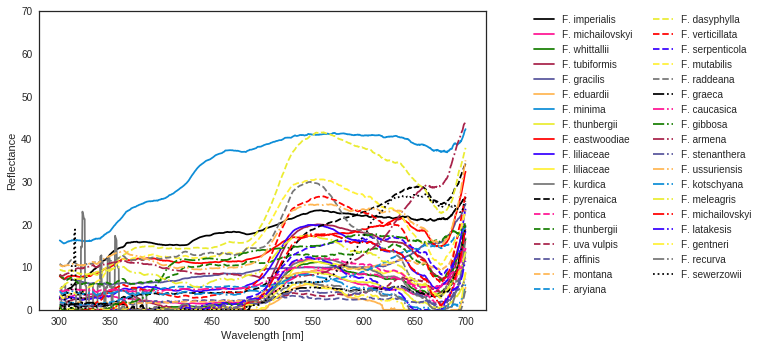

In [53]:
import matplotlib as mpl
N = 37
l_styles = ['-','--','-.',':']
m_styles = ['','.','o','^','*']
colormap = mpl.cm.Dark2.colors   # Qualitative colormap
for i,(marker,linestyle,color) in zip(range(N),itertools.product(m_styles,l_styles, col_nect)):
    plt.plot(sheets_nect[i]["nm"],sheets_nect[i]["mean"], 
             #color=mpl.colors.to_hex(col_nect[i]), 
             color = color, 
             markersize=1,
             linestyle=linestyle, marker=marker, label=nect_species[i])
    plt.ylim(0,70)
    #plt.title("Nectaries reflectance", fontsize=16)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
#plt.figsize=(10,10)
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.,ncol=2)
plt.savefig('Nectaries.jpg', bbox_inches="tight", dpi=1000)
plt.show()

### Petal outside

In [54]:
outside = []
pattern = ".+ou.+"
outside = [x for x in names if re.match(pattern,x)]

In [55]:
indexes_outside = []
for i in range(len(outside)):
    indexes_outside.append(names.index(outside[i]))

sheets_outside = []
for i in range(len(outside)):
    sheet = xls.parse(indexes_outside[i])
    sheets_outside.append(sheet)

In [56]:
#returns UV & visible spectrum
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i][(sheets_outside[i].nm > 300) & (sheets_outside[i].nm < 700)]

In [57]:
#returns mean of wavelengths (relative)
for i in range(len(sheets_outside)):
    sheets_outside[i] = sheets_outside[i].assign(mean=sheets_outside[i][columns_ref].mean(axis=1)/1000)

In [58]:
numbers = []
for i in range(1,39):
    numbers.append("Sp"+str(i))
nms = list(zip(numbers, species))
outside_species = []
for i in range(11):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms, outside[i])) 

In [59]:
for i in range(11, len(outside)):
    outside_species.append(reduce(lambda a, kv: a.replace(*kv), nms[9:], outside[i])) 

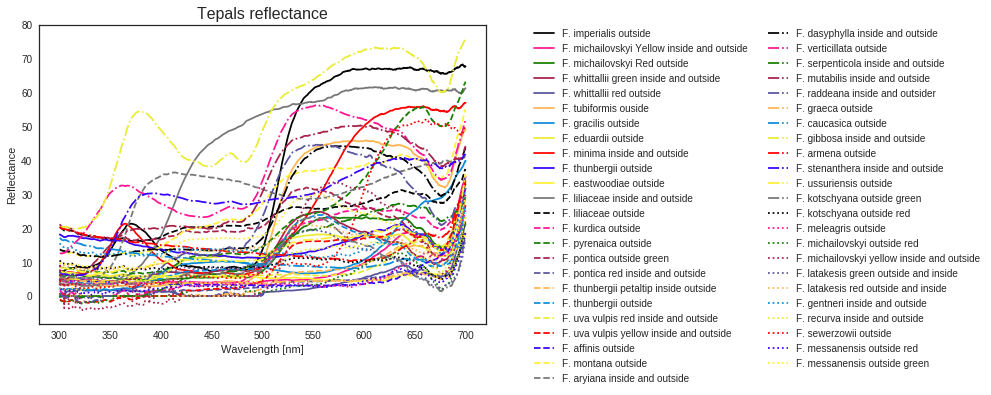

In [60]:
N = 47
l_styles = ['-','--','-.',':']
m_styles = ['','.','o','^','*']
colormap = mpl.cm.Dark2.colors   # Qualitative colormap
for i,(marker,linestyle,color) in zip(range(N),itertools.product(m_styles,l_styles, col_nect)):
    plt.plot(sheets_outside[i]["nm"],sheets_outside[i]["mean"], 
             #color=mpl.colors.to_hex(col_nect[i]), 
             color = color, 
             markersize=1,
             linestyle=linestyle, 
             marker=marker, label=outside_species[i])
plt.title("Tepals reflectance", fontsize=16)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
#plt.figsize=(20,20)
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.,ncol=2)
plt.savefig('Outside.jpg', bbox_inches="tight", dpi=1000)
plt.show()

In [61]:
#grouping species by color
green = ['F. whittallii', 'F. pontica', 'F. thunbergii', 'F. verticillata']
orange = ["F. imperialis",'F. eduardii']
pink = ['F. aryiana', 'F. gibbosa','F. stenanthera']
purple = ["F. michailovskyi",'F. tubiformis','F. gracilis', "F. kurdica",'F. pyrenaica', 
           'F. uva vulpis', 'F. affinis','F. montana', 'F. mutabilis', 'F. graeca', 
           'F. caucasica', 'F. armena','F. ussuriensis','F. kotschyana','F. meleagris', 
          "F. michailovskyi", 'F. latakesis', 'F. sewerzowii', 'F. messanensis']
red = ['F. eastwoodiae', 'F. gentneri', 'F. recurva']
white = ["F. liliaceae"]
yellow = ['F. minima','F. thunbergii','F. dasyphylla', 'F. serpenticola', 'F. raddeana']
flower_colors = ["Green", "Orange", "Pink", "Red", "White", "Yellow"]
flower = [green, orange, pink, red, white, yellow]
col_ref = ['#228B22', "#e5247e", "#00447C", 'y', '#991188',"#ffe732", 'k', '#46c4fd']

### Petals reflectance by colour of flower

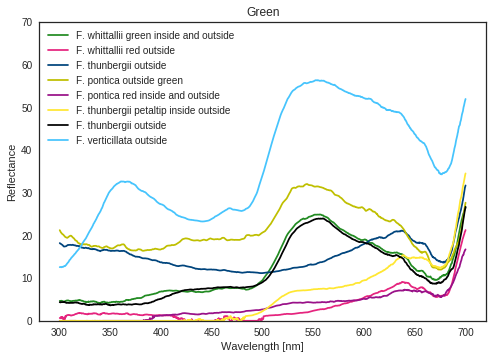

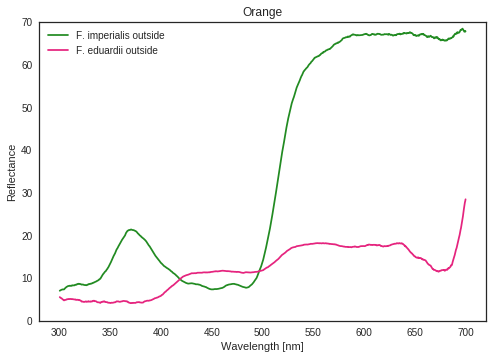

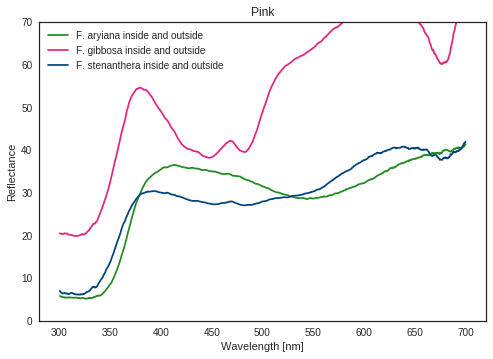

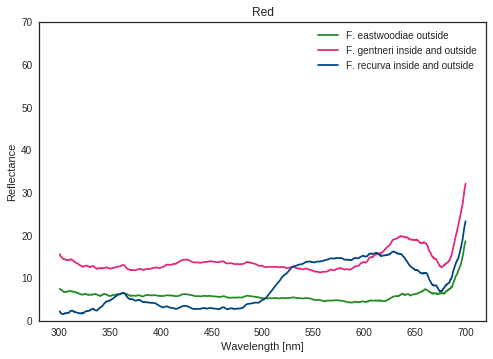

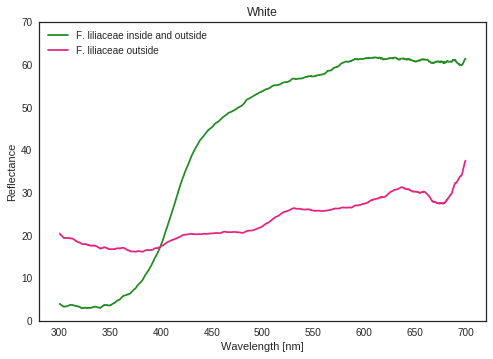

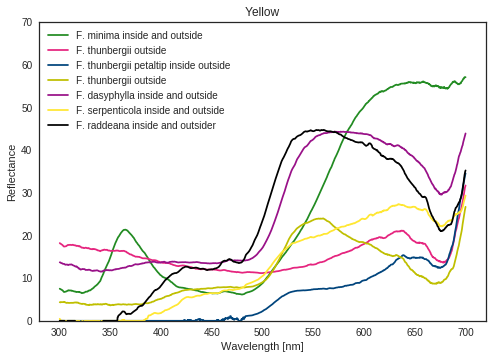

In [62]:
for z in range(len(flower)):
    #indexes of specific color flower
    matching = [i for i, x in enumerate(outside_species) for keyword in flower[z] if keyword in x]
    plt.figure()
    for i in range(len(matching)):  
        plt.plot(sheets_outside[matching[i]]["nm"], sheets_outside[matching[i]]["mean"], 
                c = col_ref[i],
                label = outside_species[matching[i]]),
        plt.legend(),
        plt.ylim(0,70)
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Reflectance")
    plt.title(flower_colors[z])
    #saving plot with proper name
    plt.savefig('{}.jpg'.format(flower_colors[z]))
plt.show()

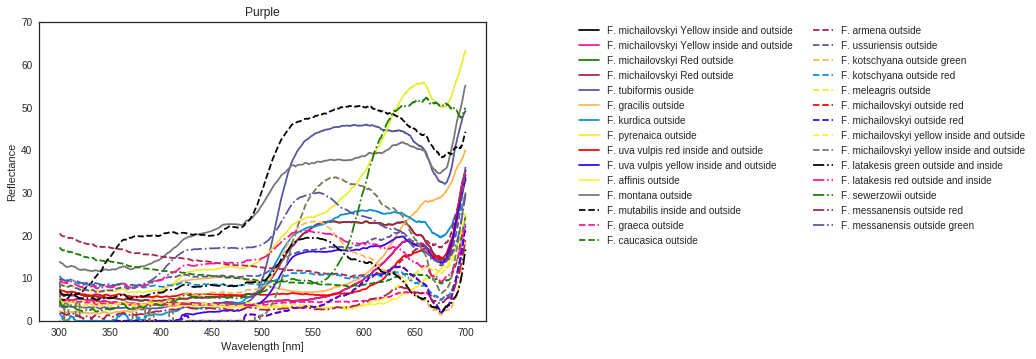

In [63]:
matching_purple = [i for i, x in enumerate(outside_species) for keyword in purple if keyword in x]
len(matching_purple)
N=29
l_styles = ['-','--','-.',':']
m_styles = ['','.','o','^','*']
colormap = mpl.cm.Dark2.colors   # Qualitative colormap
for i,(marker,linestyle,color) in zip(range(N),itertools.product(m_styles,l_styles, col_nect)):
    plt.plot(sheets_outside[matching_purple[i]]["nm"],sheets_outside[matching_purple[i]]["mean"], 
             #color=mpl.colors.to_hex(col_nect[i]), 
             color = color, 
             markersize=1,
             linestyle=linestyle, marker=marker, label=outside_species[matching_purple[i]])
    plt.ylim(0,70)
    plt.title("Purple")
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Reflectance")
#plt.figsize=(10,10)

plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.,ncol=2)
plt.savefig('purple.jpg', bbox_inches="tight", dpi=1000)
plt.show()

### Petal inside

In [64]:
inside = []
pattern = ".+in.+"
inside = [x for x in names if re.match(pattern,x)]

In [65]:
#getting inside sheets
indexes_inside = []
for i in range(len(inside)):
    indexes_inside.append(names.index(inside[i]))

sheets_inside = []
for i in range(len(inside)):
    sheet = xls.parse(indexes_inside[i])
    sheets_inside.append(sheet)

In [66]:
#UV & visible spectrum
for i in range(len(sheets_inside)):
    sheets_inside[i] = sheets_inside[i][(sheets_inside[i].nm > 300) & (sheets_inside[i].nm < 700)]

In [67]:
#returns mean of wavelengths
for i in range(len(sheets_inside)):
    sheets_inside[i] = sheets_inside[i].assign(mean=sheets_inside[i][columns_ref].mean(axis=1)/1000)

In [68]:
inside_species = []
for i in range(11):
    inside_species.append(reduce(lambda a, kv: a.replace(*kv), nms, inside[i]))

In [69]:
for i in range(11, len(outside)):
    inside_species.append(reduce(lambda a, kv: a.replace(*kv), nms[9:], outside[i]))

In [70]:
len(inside_species)

47

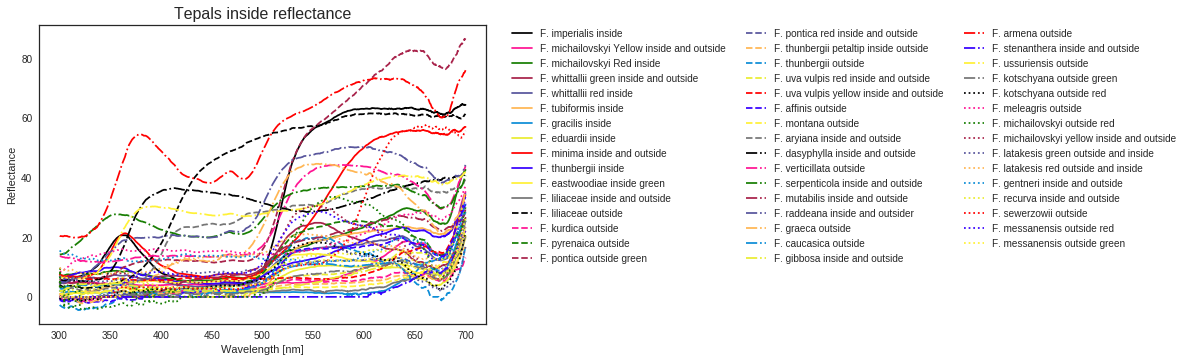

In [71]:
N = 47
l_styles = ['-','--','-.',':']
m_styles = ['','.','o','^','*']
colormap = mpl.cm.Dark2.colors   # Qualitative colormap
for i,(marker,linestyle,color) in zip(range(N),itertools.product(m_styles,l_styles, col_nect)):
    plt.plot(sheets_inside[i]["nm"],sheets_inside[i]["mean"], 
             #color=matplotlib.colors.to_hex(col[i]), 
             color = color, markersize=1,
             linestyle=linestyle, marker=marker, label=inside_species[i])
#plt.figsize=(10,10)
plt.title("Tepals inside reflectance", fontsize=16)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=3)
plt.savefig('Inside.jpg', bbox_inches="tight", dpi=1000)
plt.show()

In all cases the reflectance values were similar among most of the studied species. This indicate that the colour as a floral character seems to be conservative, which means that the pollinators preferences play a minor role. However, floral colour proved to be one of the most important characters deciding about occurrence of the pollinator shift.
The wax layer on the petals surface coses lack of reflectance in UV for several species. Red colour of the bird-pollinated species is not invisible for insect pollinators (cryptic). Red flowers are visible for insect pollinators (red coloration activates other then green receptor in insects eyes).

## Nectar properties

In [72]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
df["colors"] = df.Pollinator.apply(lambda x: col[x])

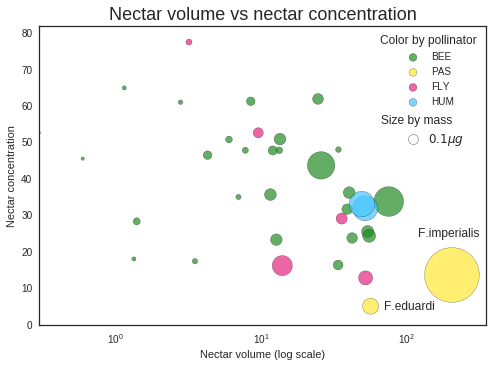

In [73]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = df.V[df.Pollinator == key], y = df.KON[df.Pollinator == key],
            s = np.array(df.MASA[df.Pollinator == key]) * 10000, 
            c = df.colors[df.Pollinator == key], alpha=0.7, edgecolors='black')

#plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Nectar concentration')
plt.title('Nectar volume vs nectar concentration', fontsize=18)
plt.xlim(0,350)

#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
plt.text(120, 24, 'F.imperialis')
plt.text(70, 4, 'F.eduardi')
lgnd = plt.legend(labels, title='Color by pollinator')
for i in range(len(col)):
    lgnd.legendHandles[i]._sizes = [60]

plt.text(67,55, "Size by mass")
plt.scatter(110, 51, s=100, c = 'white', edgecolors='k')
plt.text(140, 49.8,  r'$0.1 \mu g$')
# Show the plot
plt.show()

In [74]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets 
import numpy as np
from scipy import special
py.offline.init_notebook_mode(connected = True)
data = df
#df = df.sort_values(['pollinator'])
slope = 2.666051223553066e-05
hover_text = []
bubble_size = []

for index, row in df.iterrows():
    hover_text.append(('Species: {Gatunek}<br>'+
                      'Mass: {MASA}<br>'
                      ).format(Gatunek=row['Gatunek'],
                                            MASA=round(row['MASA'],3),
                                            ))
    bubble_size.append(row['MASA']*1000)

df['text'] = hover_text
df['size'] = bubble_size
sizeref = 2.*max(df['size'])/(100**2)

trace0 = go.Scatter(
    x=df['V'][df['Pollinator'] == 'BEE'],
    y=df['KON'][df['Pollinator'] == 'BEE'],
    mode='markers',
    name='BEE',
    text=df['text'][df['Pollinator'] == 'BEE'],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=df['size'][df['Pollinator'] == 'BEE'],
        color = '#228B22',
        line=dict(
            width=2
        ),
    )
)
trace1 = go.Scatter(
    x=df['V'][df['Pollinator'] == 'PAS'],
    y=df['KON'][df['Pollinator'] == 'PAS'],
    mode='markers',
    name='PAS',
    text=df['text'][df['Pollinator'] == 'PAS'],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=df['size'][df['Pollinator'] == 'PAS'],
        color = '#ffe732',
        line=dict(
            width=2
        ),
    )
)
trace2 = go.Scatter(
    x=df['V'][df['Pollinator'] == 'FLY'],
    y=df['KON'][df['Pollinator'] == 'FLY'],
    mode='markers',
    name='FLY',
    text=df['text'][df['Pollinator'] == 'FLY'],
    
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=df['size'][df['Pollinator'] == 'FLY'],
        color = '#e5247e',
        line=dict(
            width=2
        ),
    )
)
trace3 = go.Scatter(
      x=df['V'][df['Pollinator'] == 'HUM'],
    y=df['KON'][df['Pollinator'] == 'HUM'],
    mode='markers',
    name='HUM',
    text=df['text'][df['Pollinator'] == 'HUM'],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=df['size'][df['Pollinator'] == 'HUM'],
        color='#46c4fd',
        line=dict(
            width=2
        ),
    )
)

data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Nectar volume vs nectar concentration',
    xaxis=dict(
        title='Nectar volume (log scale)',
        gridcolor='rgb(255, 255, 255)',
        #range=[2.003297660701705, 5.191505530708712],
        type='log',
        zerolinewidth=1,
        hoverformat = '.2f',
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Nectar concentration',
        gridcolor='rgb(255, 255, 255)',
        #range=[36.12621671352166, 91.72921793264332],
        zerolinewidth=1,
        ticklen=5,
        hoverformat = '.2f',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = dict(data=data, layout=layout)
py.offline.iplot(fig)

In [75]:
col = {'Fritillaria':'#228B22', 'Rhinopetalum':'red', 'Liliorhiza':"#e5247e", 
       'Petilium':'#46c4fd', 'Other': "#00447C", 'Theresia': '#991188','Korolkowia': "#ffe732", "Japonica":'k'}

In [76]:
df["colors"] = df.Subspecies.apply(lambda x: col[x])

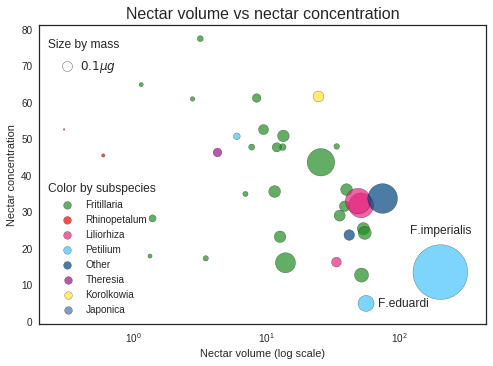

In [77]:
labels =[]
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = df.V[df.Subspecies == key], y = df.KON[df.Subspecies == key],
            s = np.array(df.MASA[df.Subspecies == key]) * 10000, 
            c = df.colors[df.Subspecies == key], alpha=0.7, edgecolors='black')

#plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Nectar concentration')
plt.title('Nectar volume vs nectar concentration', fontsize=16)
plt.xlim(0,450)
#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
plt.text(120, 24, 'F.imperialis')
plt.text(70, 4, 'F.eduardi')
lgnd = plt.legend(labels, title='Color by subspecies', loc="lower left")
for i in range(len(col)):
    lgnd.legendHandles[i]._sizes = [60]

plt.text(0.23,75, "Size by mass")
plt.scatter(0.32, 70, s=100, c = 'white', edgecolors='k')
plt.text(0.4, 69,  r'$0.1 \mu g$')
# Show the plot
plt.show()

In [78]:
#total concentration of AA's in nectar
amino["Total"] = amino.iloc[:,3:33].sum(axis = 1)

In [79]:
#mean concentration of AA's, nectar volume and nectar concentration
amino_mean = amino.groupby('Gatunek').mean().reset_index()

In [80]:
amino_mean["Pollinator"] = amino_mean["Gatunek"].apply(pollinator)

In [81]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
amino_mean["colors"] = amino_mean.Pollinator.apply(lambda x: col[x])

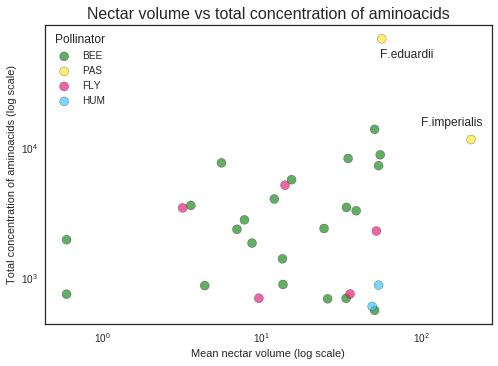

In [82]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = amino_mean.v[amino_mean.Pollinator == key], 
                y = amino_mean.Total[amino_mean.Pollinator == key],
                s = 80,
                c = amino_mean.colors[amino_mean.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Mean nectar volume (log scale)')
plt.ylabel('Total concentration of aminoacids (log scale)')
plt.title('Nectar volume vs total concentration of aminoacids', fontsize=16)

plt.text(100, 15000, 'F.imperialis')
plt.text(55, 50000, 'F.eduardii')
#lgnd = plt.legend(labels, title='Color by pollinator')
#for i in range(len(col)):
#    lgnd.legendHandles[i]._sizes = [60]
plt.legend(labels, title = "Pollinator", loc = 'upper left')
# Show the plot
plt.show()

In [83]:
#Exploratory analysis of aminoacids in nectar by pollinator
df2 = amino.drop(["Gatunek", "ORIGIN", "dominujący cukier"], axis=1)
#reshaping df
df2 = pd.melt(df2, id_vars=['pollinator'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 3 columns):
pollinator    1749 non-null object
variable      1749 non-null object
value         1738 non-null float64
dtypes: float64(1), object(2)
memory usage: 41.1+ KB


In [84]:
#selecting essential aa's except GLN
essential = df2[(df2.variable == "ASP")| (df2.variable == "GLU") | (df2.variable == "SER") |
         (df2.variable == "PRO") | (df2.variable == "GLY")| (df2.variable == "ALA") | 
         (df2.variable == "VAL")]

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



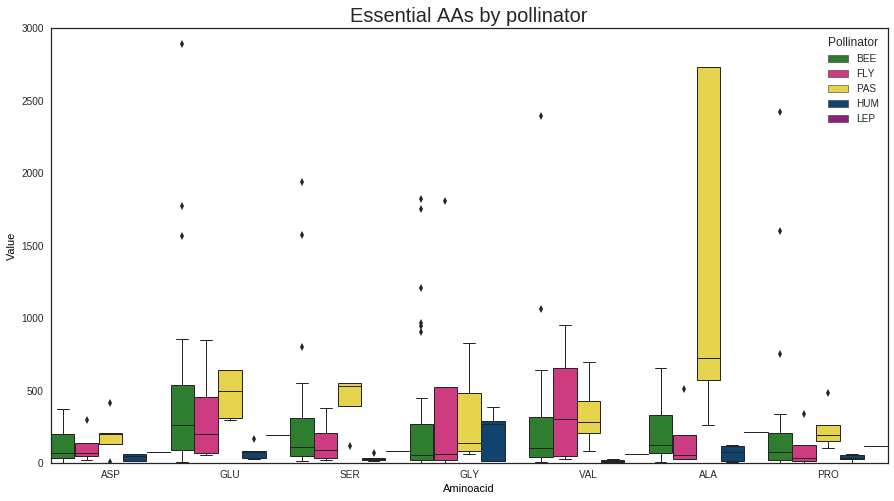

In [85]:
#boxplots grouped by pollinator
plt.figure(figsize=(15,8))
sns.set_style("white")
ax = sns.boxplot(x="variable", y="value", hue="pollinator", data=essential, linewidth=1, width=1,
                 palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Aminoacid")
plt.ylabel("Value")
plt.legend(title="Pollinator")
plt.title("Essential AAs by pollinator", fontsize=20)
#ax.set_facecolor('white')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
ax.set_ylim(0,3000)
plt.show()

In [86]:
df2.variable.unique()

array(['ASP', 'GLU', 'ASN', 'SER', 'GLN', 'GLY', 'THR', 'VAL', 'MET',
       'LEU', 'LYS', 'ARG', 'BALA', 'ALA', 'TYR', 'PRO', 'TRP', 'PHE',
       'ILE', 'AABA', 'CY2', 'OSER+HIS', 'CIT', 'NVA', 'ORN', 'TAU',
       'GABA', 'HYP', 'SAR', 'BABA', 'v', '%', 'Total'], dtype=object)

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



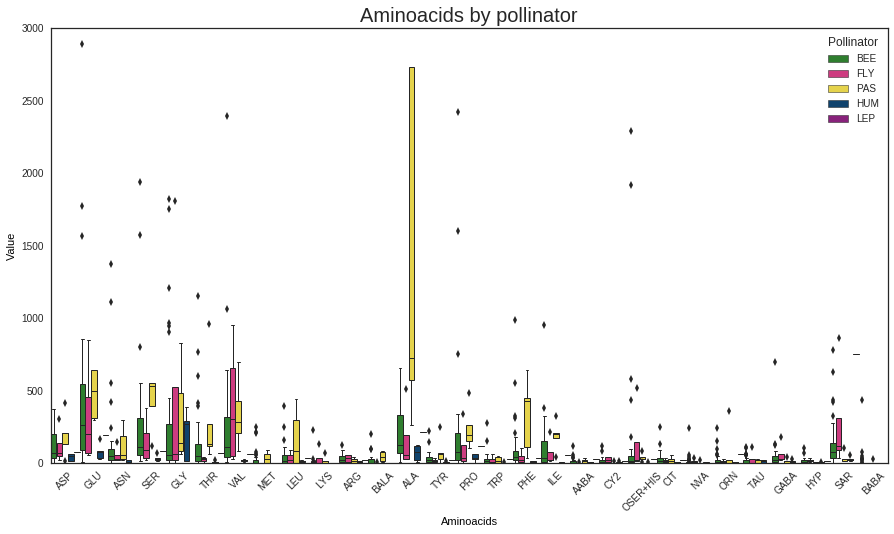

In [87]:
#boxplots grouped by pollinator
sns.set_style("white")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="variable", y="value", hue="pollinator", 
                 data=df2[(df2.variable!="GLN") & (df2.variable !="Total") &
                         (df2.variable != 'v') & (df2.variable != '%')], 
                 linewidth=1, width=1,
                 palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Aminoacids")
plt.ylabel("Value")
plt.legend(title="Pollinator")
plt.title("Aminoacids by pollinator", fontsize = 20)
plt.xticks(rotation=45)
ax.set_facecolor('white')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
ax.set_ylim(0,3000)
plt.show()

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



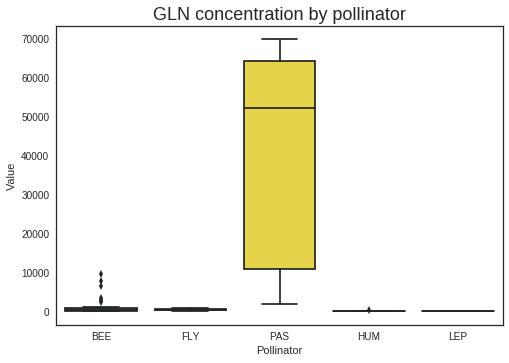

In [88]:
sns.boxplot(data=df2[df2.variable == "GLN"], x='pollinator', y='value', 
           palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Pollinator")
plt.ylabel("Value")
plt.title("GLN concentration by pollinator", fontsize = 18)
plt.show()

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



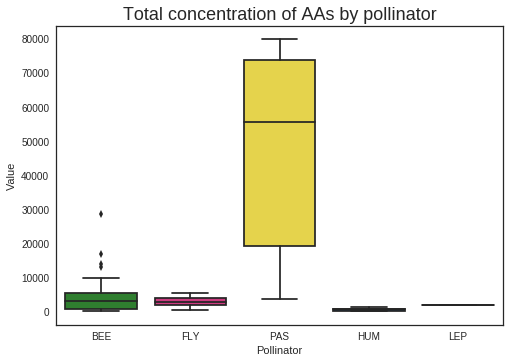

In [89]:
sns.boxplot(data=df2[df2.variable == "Total"], x='pollinator', y='value', 
           palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Pollinator")
plt.ylabel("Value")
plt.title("Total concentration of AAs by pollinator", fontsize=18)
plt.show()

In [90]:
#prepapring data
X = amino.drop(["pollinator", "Gatunek", "Total", "v", "%", "ORIGIN", "dominujący cukier" ], axis=1)
y = amino.pollinator
index = X.columns
X = StandardScaler().fit_transform(X)

In [91]:
models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
         AdaBoostClassifier(), xgb.XGBClassifier(),
          BaggingClassifier(DecisionTreeClassifier(), bootstrap=False)]

for m in models:
    
    print("%s %.1f%%" % (m.__class__.__name__, cross_val_score(m,X,y,cv=3).mean()*100))

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/hom

LogisticRegression 63.1%
SVC 72.4%
DecisionTreeClassifier 72.2%
RandomForestClassifier 74.1%
AdaBoostClassifier 73.9%
XGBClassifier 78.3%
BaggingClassifier 74.1%


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.



/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.



0.783333333333


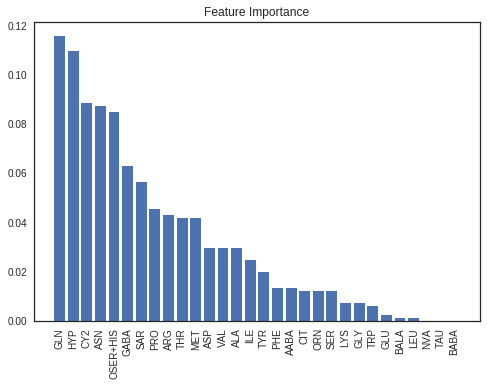

In [92]:
model = xgb.XGBClassifier()
print(cross_val_score(model,X,y,cv=3).mean())
pd.Series(model.fit(X,y).feature_importances_, index = index).sort_values(ascending=False)
# Sort feature importances in descending order
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [index[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

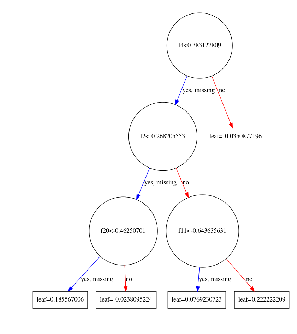

In [93]:
plot_tree(model)
#plt.savefig("tree.png", dpi=800)
plt.show()

In [94]:
y.value_counts()

BEE    38
PAS     5
HUM     5
FLY     4
LEP     1
Name: pollinator, dtype: int64

In [95]:
y_pred = cross_val_predict(model, X, y, cv=3)
conf_mat = confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))
labels=['BEE', 'FLY', 'HUM', 'LEP','PAS']

             precision    recall  f1-score   support

        BEE       0.77      0.97      0.86        38
        FLY       0.00      0.00      0.00         4
        HUM       0.75      0.60      0.67         5
        LEP       0.00      0.00      0.00         1
        PAS       1.00      0.20      0.33         5

avg / total       0.72      0.77      0.71        53



/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Confusion matrix, without normalization
[[37  0  1  0  0]
 [ 4  0  0  0  0]
 [ 2  0  3  0  0]
 [ 1  0  0  0  0]
 [ 4  0  0  0  1]]


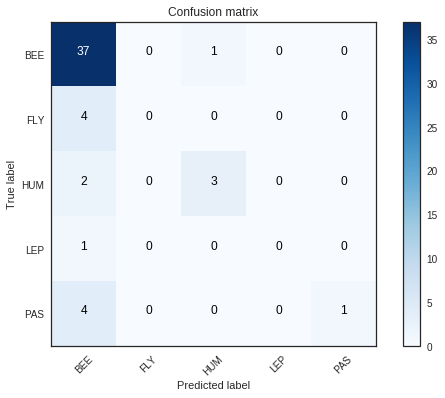

In [96]:
plt.figure()
plot_confusion_matrix(conf_mat, classes=labels,
                      title='Confusion matrix')
plt.show()

In [97]:
amino.dropna(inplace=True)
X_ext = amino.drop(["Gatunek", "ORIGIN", "pollinator"], axis=1)
X_ext = pd.get_dummies(X_ext,drop_first=True)
index_ext = X_ext.columns
y_ext = amino["pollinator"]
models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
         AdaBoostClassifier(), xgb.XGBClassifier(),
          BaggingClassifier(DecisionTreeClassifier(), bootstrap=False)]

for m in models:
    
    print("%s %.1f%%" % (m.__class__.__name__, cross_val_score(m,X_ext,y_ext,cv=3).mean()*100))


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/hom

LogisticRegression 67.2%
SVC 68.1%
DecisionTreeClassifier 62.8%
RandomForestClassifier 76.1%
AdaBoostClassifier 74.3%
XGBClassifier 82.2%
BaggingClassifier 65.7%


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.



/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.



0.822222222222


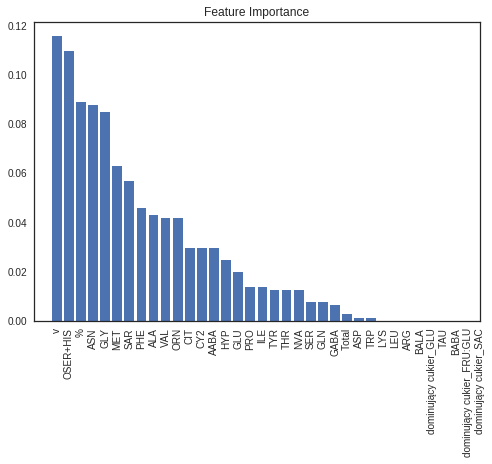

In [98]:
model_ext = xgb.XGBClassifier(n_estimators=100)
print(cross_val_score(model_ext,X_ext,y_ext,cv=3).mean())
model_ext.fit(X_ext,y_ext)
importances_ext = model_ext.feature_importances_
indices_ext = np.argsort(importances_ext)[::-1]

# Rearrange feature names so they match the sorted feature importances
names_ext = [index_ext[i] for i in indices_ext]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_ext.shape[1]), names_ext, rotation=90)

# Show plot
plt.show()

In [99]:
y_pred_ext = cross_val_predict(model, X_ext, y_ext, cv=3)
conf_mat_ext = confusion_matrix(y_ext, y_pred_ext)
print(classification_report(y_ext, y_pred_ext))

             precision    recall  f1-score   support

        BEE       0.82      0.93      0.87        29
        FLY       0.00      0.00      0.00         3
        HUM       0.80      0.80      0.80         5
        LEP       0.00      0.00      0.00         1
        PAS       1.00      0.80      0.89         5

avg / total       0.76      0.81      0.78        43



/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Confusion matrix, without normalization
[[27  1  1  0  0]
 [ 3  0  0  0  0]
 [ 1  0  4  0  0]
 [ 1  0  0  0  0]
 [ 1  0  0  0  4]]


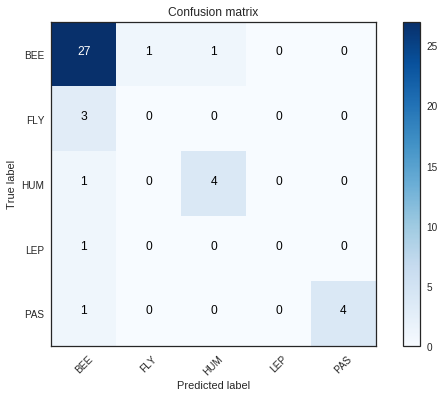

In [100]:
plt.figure()
plot_confusion_matrix(conf_mat_ext, classes=['BEE', 'FLY', 'HUM','LEP', 'PAS'],
                      title='Confusion matrix')
plt.show()

In [101]:
nectar = nectar[["Gatunek","V", "KON", "MASA"]]

In [102]:
nectar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 4 columns):
Gatunek    3029 non-null object
V          505 non-null float64
KON        572 non-null float64
MASA       477 non-null float64
dtypes: float64(3), object(1)
memory usage: 94.7+ KB


In [103]:
nectar.loc[nectar.MASA.isnull(), 'MASA'] = nectar.groupby('Gatunek').MASA.transform('mean')

In [104]:
nectar.loc[nectar.V.isnull(), 'V'] = nectar.groupby('Gatunek').V.transform('mean')
nectar.loc[nectar.KON.isnull(), 'KON'] = nectar.groupby('Gatunek').KON.transform('mean')

In [105]:
nectar = nectar.dropna()

In [106]:
nectar['Pollinator'] = nectar["Gatunek"].apply(pollinator)

In [107]:
nectar.Pollinator.value_counts()

BEE    1952
PAS     399
HUM     140
FLY      59
Name: Pollinator, dtype: int64

In [108]:
#area = data.groupby(['Gatunek']).agg({'V': 'mean','POW': 'mean'}).reset_index()

In [109]:
#prepapring data
X = nectar.drop(["Pollinator", "Gatunek"], axis=1)
y = nectar.Pollinator
index_nec = X.columns
X = StandardScaler().fit_transform(X)

In [110]:
le = LabelEncoder()
le.fit(y)
y_e = le.transform(y)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y_e, test_size=0.25, random_state=42)

In [112]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(probability=True),  
          RandomForestClassifier(), 
          AdaBoostClassifier(),
         xgb.XGBClassifier()]

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = np.round(y_pred)

    accuracy = accuracy_score(y_test, predictions)
    print("%s accuracy: %.2f%%" % (model.__class__.__name__,accuracy * 100.0))

LogisticRegression accuracy: 91.07%
DecisionTreeClassifier accuracy: 96.71%
SVC accuracy: 94.83%
RandomForestClassifier accuracy: 97.34%
AdaBoostClassifier accuracy: 88.09%
XGBClassifier accuracy: 96.87%


In [113]:
model_nec = RandomForestClassifier()
model_nec.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat_nec = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[475   0   5   0]
 [  4  12   0   0]
 [ 10   0  31   0]
 [  1   0   0 100]]


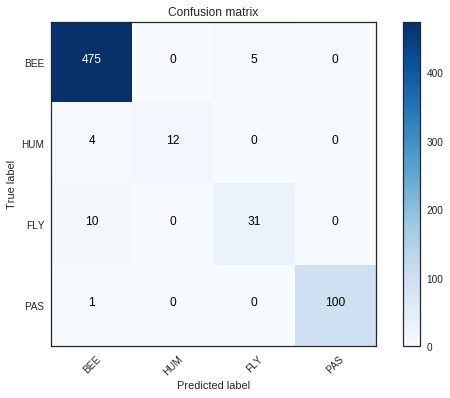

In [114]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat_nec, classes=["BEE","HUM","FLY", "PAS"],
                      title='Confusion matrix')
plt.show()

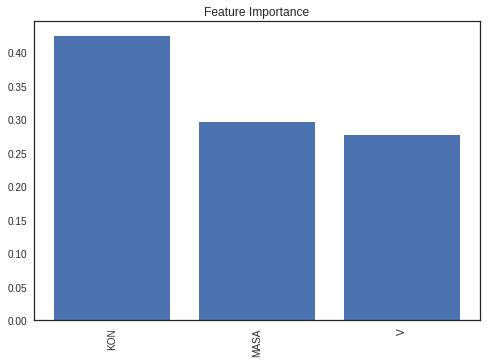

In [115]:
importances = model_nec.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [index_nec[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

AAs concertation and composition in Fritillaria might be influenced by several factors. While the phylogeny plays a role, as several closely related species have similar AAs composition and concertation, the prevailing evidence is that AA composition and concentration can be variable even within a single species, as well as between closely related taxa.
Similarly to subgenus Petilium, differences in AAs concentration and composition in the nectar of closely related species in subgenus Liliorhiza was found. Fritillaria affinis, F. eastwoodiae, F. liliacea produced nectar with higher AAs concentration. Furthermore, a higher amount of bee-preferred proline was present in presumably insect-pollinated species of this subgenus, which also indicates a strong influence of pollinators. 
Changes in AAs concentration and composition might play an important role in attracting new floral visitors in case of a pollinator shift. Analysis revealed high concentration of AAs in passerine bird-pollinated species, and very low AAs concentration in hummingbird-pollinated species. This tendencies were not reflected in closely related species from the same subgenus. 
Such low concentration of AAs in hummingbird-pollinated flowers may also have a repellent effect, aiding avoidance of competition with bees favouring higher AAs concentrations (Baker and Baker 1982; Nicolson 2007;Heil 2011), whereas the shortage of AAs in birds’ diet could be overcome via additional food sources, e.g. fruits (Nicolson 2007). 
Both the AA's concentration and amount of nectar produced (V, MASA) influence strongly on the pollinator type.

## References
Verhoeven Ch., Ren ZX, Lunau K. (2018) FALSE-COLOUR PHOTOGRAPHY: A NOVEL DIGITAL APPROACH TO VISUALIZE THE BEE VIEW OF FLOWERS Journal of Pollination Ecology, 23(12), 2018, pp 102-118